# Predicting Diabetes Risk Using CDC Health Indicators

## Project Overview

This project uses machine learning classification models to predict diabetes risk based on health and lifestyle indicators from the CDC's Behavioral Risk Factor Surveillance System (BRFSS) 2015 survey data.

**Research Question:** Can we accurately predict an individual's diabetes risk using health and lifestyle indicators?

**Dataset:** 253,680 survey responses with 21 health-related features

**Final Model:** Logistic Regression with 76% recall on at-risk individuals and 0.818 AUC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

print("Libraries loaded successfully")

Libraries loaded successfully


## Data Exploration

In [2]:
# Load the dataset
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
print('Total number of records: ', df.shape[0])

Total number of records:  253680


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

All of the datatypes are correct and there are no missing values

In [5]:
df.nunique()

Diabetes_012             3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

Number of outputs for each column is as expected and nothing out of the ordinary

In [6]:
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


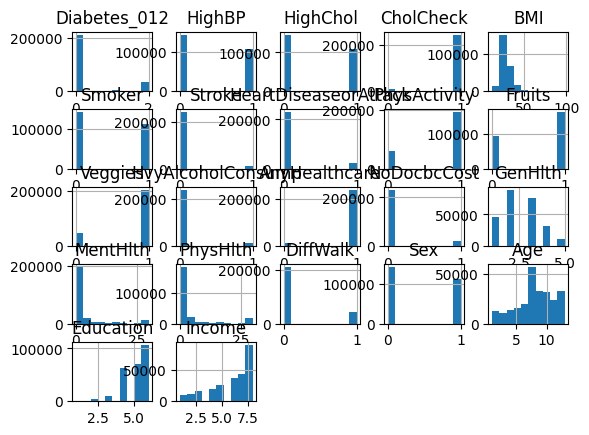

In [7]:
df.hist();

In [8]:
df.Diabetes_012.value_counts().sort_index()

Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64

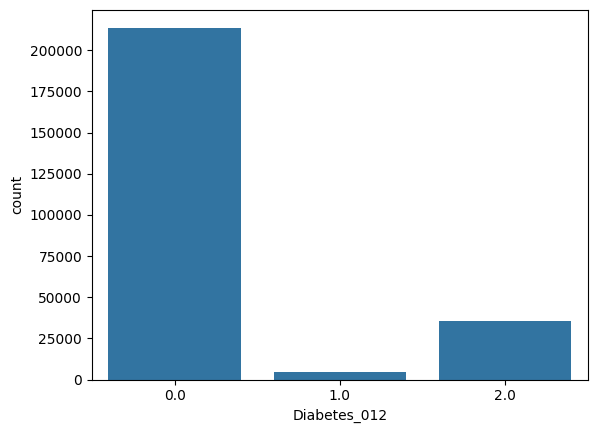

In [9]:
sns.countplot(x='Diabetes_012', data=df);

Majority of the respondants, 213,703, don't have diabetic while 35,346 are diabetic and 4,631 are prediabetic. Thus, there is a significant class imbalance in this dataset.

In [10]:
# Define Features and Target
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (253680, 21)
Target shape: (253680,)


In [11]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [12]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_012, dtype: float64

In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 202944 samples
Test set: 50736 samples


In [14]:
# Check class distribution in train set
print("Training set class distribution:")
print(y_train.value_counts().sort_index())

Training set class distribution:
Diabetes_012
0.0    170962
1.0      3705
2.0     28277
Name: count, dtype: int64


In [ ]:
# Scale features for logistic regression to prevent non binary features from dominating the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete")

Scaling complete


In [ ]:
# Compute class weights to handle class imbalance so the model doesn’t become biased toward the majority class.
classes = np.array([0, 1, 2])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.395690270352476), np.int64(1): np.float64(18.258569500674763), np.int64(2): np.float64(2.392332991477172)}


## Handling Class Imbalance

The dataset has significant class imbalance. Most respondents (84%) have no diabetes, while prediabetes represents only about 2% of the data. If we train a model on this imbalanced data as-is, it will likely predict "no diabetes" for most cases and still achieve high accuracy while failing to identify the people who actually need attention.

To address this, we computed class weights that assign higher importance to minority classes during training. The weights are inversely proportional to class frequency:

- No diabetes (Class 0): 0.40 — most common, lowest weight
- Prediabetes (Class 1): 18.26 — rarest, highest weight
- Diabetes (Class 2): 2.39 — moderate weight

When training, the model is penalized more heavily for misclassifying prediabetes and diabetes cases. This encourages the model to learn patterns for all classes rather than defaulting to the majority class.

In [17]:
# Logistic Regression (uses scaled data)
log_model = LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

print("Logistic Regression trained")

Logistic Regression trained


## Why Scale for Logistic Regression but Not for Tree Models?

Logistic Regression learns by adjusting coefficients for each feature. If one feature ranges from 0 to 100 and another is just 0 or 1, the larger feature will dominate the learning process simply because its numbers are bigger. Scaling puts everything on the same playing field so no single feature overpowers the others just because of its range.

Random Forest and XGBoost work differently. They split data by asking questions like "is BMI greater than 25?" The actual scale does not matter because the model only cares about the order of values and where to draw the line. Whether BMI goes from 12 to 98 or 0 to 1, the splits would happen at the same relative points. So scaling does nothing for tree-based models.

In [18]:
# Random Forest (uses unscaled data)
rf_model = RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest trained")


Random Forest trained


In [19]:
# XGBoost (uses unscaled data, needs sample weights differently)
xgb_model = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
xgb_preds = xgb_model.predict(X_test)

print("XGBoost trained")

c:\Users\ruh07\anaconda3\envs\diabetes\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:27:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained


## Model Evaluation

We evaluate each model using precision, recall, and F1-score for each class. Accuracy alone is misleading with imbalanced data, so we focus on how well each model identifies prediabetes and diabetes cases.

In [20]:
print("=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)
print(classification_report(y_test, log_preds, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

LOGISTIC REGRESSION
              precision    recall  f1-score   support

 No Diabetes       0.95      0.66      0.78     42741
 Prediabetes       0.03      0.33      0.06       926
    Diabetes       0.35      0.58      0.44      7069

    accuracy                           0.65     50736
   macro avg       0.45      0.52      0.43     50736
weighted avg       0.85      0.65      0.72     50736



In [21]:
print("=" * 60)
print("RANDOM FOREST")
print("=" * 60)
print(classification_report(y_test, rf_preds, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

RANDOM FOREST
              precision    recall  f1-score   support

 No Diabetes       0.86      0.97      0.91     42741
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.47      0.16      0.24      7069

    accuracy                           0.84     50736
   macro avg       0.44      0.38      0.38     50736
weighted avg       0.79      0.84      0.80     50736



In [22]:
print("=" * 60)
print("XGBOOST")
print("=" * 60)
print(classification_report(y_test, xgb_preds, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

XGBOOST
              precision    recall  f1-score   support

 No Diabetes       0.95      0.66      0.78     42741
 Prediabetes       0.03      0.23      0.05       926
    Diabetes       0.33      0.64      0.44      7069

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.85      0.65      0.72     50736



Random Forest has the highest accuracy (84%) but it's useless — it completely ignores prediabetes (0% recall) and barely catches diabetes. It just predicts "no diabetes" for almost everyone.
Logistic Regression has the best prediabetes recall (33%) — not great, but it's actually trying to find them. Also decent diabetes recall (58%).
XGBoost is similar to Logistic Regression but slightly worse on prediabetes.

## Why SMOTE?

Class weights alone did not help with prediabetes. The model still could not identify that class at all. SMOTE takes a different approach. Instead of adjusting how mistakes are penalized, it creates synthetic samples of the minority class by interpolating between existing samples and their nearest neighbors. This gives the model more examples of prediabetes to learn from. Worth a shot to see if more training samples help where class weights failed.

In [23]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts().sort_index())
print(f"\nAfter SMOTE:")
print(y_train_smote.value_counts().sort_index())

Before SMOTE:
Diabetes_012
0.0    170962
1.0      3705
2.0     28277
Name: count, dtype: int64

After SMOTE:
Diabetes_012
0.0    170962
1.0    170962
2.0    170962
Name: count, dtype: int64


In [24]:
# Scale the SMOTE data for Logistic Regression
X_train_smote_scaled = scaler.fit_transform(X_train_smote)

print("SMOTE data scaled")

SMOTE data scaled


In [25]:
# Logistic Regression with SMOTE
log_model_smote = LogisticRegression(max_iter=1000, random_state=42)
log_model_smote.fit(X_train_smote_scaled, y_train_smote)
log_preds_smote = log_model_smote.predict(X_test_scaled)

print("Logistic Regression (SMOTE) trained")

Logistic Regression (SMOTE) trained


In [26]:
# Random Forest with SMOTE
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_smote.fit(X_train_smote, y_train_smote)
rf_preds_smote = rf_model_smote.predict(X_test)

print("Random Forest (SMOTE) trained")

Random Forest (SMOTE) trained


In [27]:
# XGBoost with SMOTE
xgb_model_smote = XGBClassifier(random_state=42, n_estimators=100, eval_metric='mlogloss')
xgb_model_smote.fit(X_train_smote, y_train_smote)
xgb_preds_smote = xgb_model_smote.predict(X_test)

print("XGBoost (SMOTE) trained")

XGBoost (SMOTE) trained


In [28]:
print("=" * 60)
print("LOGISTIC REGRESSION (SMOTE)")
print("=" * 60)
print(classification_report(y_test, log_preds_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

LOGISTIC REGRESSION (SMOTE)
              precision    recall  f1-score   support

 No Diabetes       0.97      0.48      0.64     42741
 Prediabetes       0.02      0.28      0.04       926
    Diabetes       0.29      0.75      0.42      7069

    accuracy                           0.51     50736
   macro avg       0.43      0.50      0.37     50736
weighted avg       0.86      0.51      0.60     50736



In [29]:
print("=" * 60)
print("RANDOM FOREST (SMOTE)")
print("=" * 60)
print(classification_report(y_test, rf_preds_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

RANDOM FOREST (SMOTE)
              precision    recall  f1-score   support

 No Diabetes       0.87      0.96      0.91     42741
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.46      0.22      0.30      7069

    accuracy                           0.84     50736
   macro avg       0.44      0.39      0.40     50736
weighted avg       0.79      0.84      0.81     50736



In [30]:
print("=" * 60)
print("XGBOOST (SMOTE)")
print("=" * 60)
print(classification_report(y_test, xgb_preds_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

XGBOOST (SMOTE)
              precision    recall  f1-score   support

 No Diabetes       0.87      0.96      0.91     42741
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.51      0.24      0.33      7069

    accuracy                           0.85     50736
   macro avg       0.46      0.40      0.42     50736
weighted avg       0.80      0.85      0.82     50736



c:\Users\ruh07\anaconda3\envs\diabetes\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ruh07\anaconda3\envs\diabetes\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ruh07\anaconda3\envs\diabetes\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

## Analysis of 3-Class Results

The 3-class models struggled to identify prediabetes cases effectively. The best prediabetes recall achieved was 33% with Logistic Regression using class weights. SMOTE oversampling did not improve results also.

This difficulty likely stems from prediabetes cases being clinically similar to the no-diabetes group in terms of lifestyle indicators. Without lab values like blood glucose, the features may not provide enough separation.

**Decision:** Given these limitations, we pivot to binary classification by combining prediabetes and diabetes into a single "At Risk" class. This reframing is still clinically meaningful — the goal becomes identifying individuals who need further screening or intervention.

## Switching to Binary Classification

The 3-class model struggled to identify prediabetes cases due to their similarity to the no-diabetes group. To improve predictive performance, we combine prediabetes and diabetes into a single "At Risk" class.

- 0 = No diabetes
- 1 = At Risk (prediabetes or diabetes)

In [31]:
# Create binary target
y_binary = y.apply(lambda x: 0 if x == 0 else 1)

# Verify
print("Binary class distribution:")
print(y_binary.value_counts().sort_index())

Binary class distribution:
Diabetes_012
0    213703
1     39977
Name: count, dtype: int64


In [32]:
# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

print(f"Training set: {X_train_b.shape[0]} samples")
print(f"Test set: {X_test_b.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train_b.value_counts().sort_index())

Training set: 202944 samples
Test set: 50736 samples

Training class distribution:
Diabetes_012
0    170962
1     31982
Name: count, dtype: int64


In [33]:
# Scale and compute class weights
scaler_b = StandardScaler()
X_train_b_scaled = scaler_b.fit_transform(X_train_b)
X_test_b_scaled = scaler_b.transform(X_test_b)

classes_b = np.array([0, 1])
weights_b = compute_class_weight(class_weight='balanced', classes=classes_b, y=y_train_b)
class_weights_b = dict(zip(classes_b, weights_b))

print("Class weights:", class_weights_b)

Class weights: {np.int64(0): np.float64(0.593535405528714), np.int64(1): np.float64(3.172784691388906)}


In [34]:
# Logistic Regression (binary)
log_binary = LogisticRegression(class_weight=class_weights_b, max_iter=1000, random_state=42)
log_binary.fit(X_train_b_scaled, y_train_b)
log_preds_b = log_binary.predict(X_test_b_scaled)

print("Logistic Regression trained")

Logistic Regression trained


In [35]:
# Random Forest (binary)
rf_binary = RandomForestClassifier(class_weight=class_weights_b, n_estimators=100, random_state=42, n_jobs=-1)
rf_binary.fit(X_train_b, y_train_b)
rf_preds_b = rf_binary.predict(X_test_b)

print("Random Forest trained")

Random Forest trained


In [36]:
# XGBoost (binary)
xgb_binary = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
xgb_binary.fit(X_train_b, y_train_b, sample_weight=[class_weights_b[y] for y in y_train_b])
xgb_preds_b = xgb_binary.predict(X_test_b)

print("XGBoost trained")

XGBoost trained


In [37]:
print("=" * 60)
print("LOGISTIC REGRESSION (Binary)")
print("=" * 60)
print(classification_report(y_test_b, log_preds_b, target_names=['No Diabetes', 'At Risk']))

print("=" * 60)
print("RANDOM FOREST (Binary)")
print("=" * 60)
print(classification_report(y_test_b, rf_preds_b, target_names=['No Diabetes', 'At Risk']))

print("=" * 60)
print("XGBOOST (Binary)")
print("=" * 60)
print(classification_report(y_test_b, xgb_preds_b, target_names=['No Diabetes', 'At Risk']))

LOGISTIC REGRESSION (Binary)
              precision    recall  f1-score   support

 No Diabetes       0.94      0.72      0.82     42741
     At Risk       0.34      0.76      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.73      0.76     50736

RANDOM FOREST (Binary)
              precision    recall  f1-score   support

 No Diabetes       0.86      0.96      0.91     42741
     At Risk       0.49      0.19      0.28      7995

    accuracy                           0.84     50736
   macro avg       0.68      0.58      0.59     50736
weighted avg       0.80      0.84      0.81     50736

XGBOOST (Binary)
              precision    recall  f1-score   support

 No Diabetes       0.94      0.72      0.81     42741
     At Risk       0.33      0.76      0.46      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.74      0.64     50736
weigh

## Model Evaluation Visualizations

Now that we have trained our binary classification models, we will evaluate them visually using confusion matrices and ROC curves. These visualizations help us understand model performance beyond single metrics.

### Confusion Matrices

A confusion matrix shows how many predictions were correct and where the model made errors. Each cell represents:
- True Negatives (top-left): Correctly predicted No Diabetes
- False Positives (top-right): Predicted At Risk but actually No Diabetes
- False Negatives (bottom-left): Predicted No Diabetes but actually At Risk
- True Positives (bottom-right): Correctly predicted At Risk

For healthcare screening, we want to minimize false negatives since missing at-risk individuals has serious consequences.

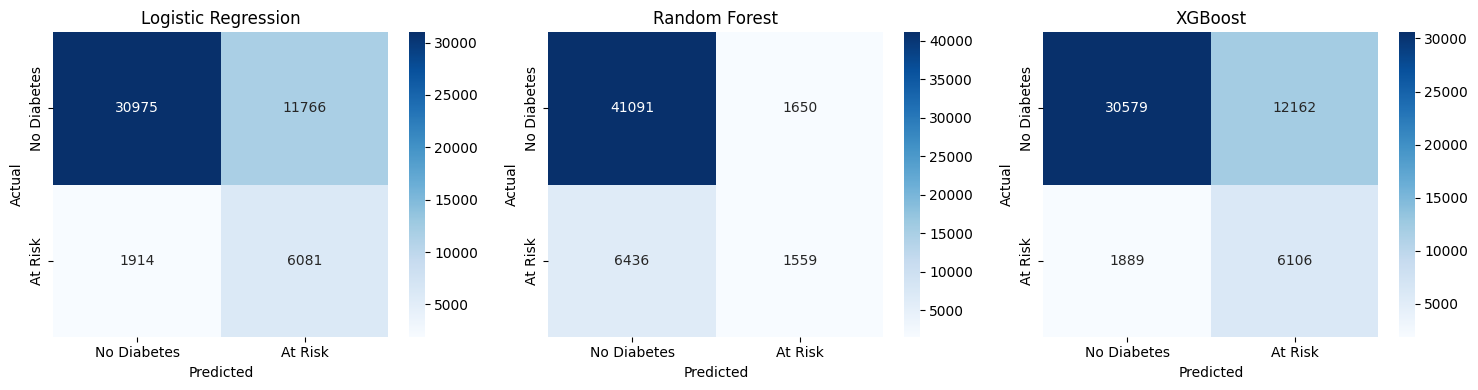

In [38]:
# Create confusion matrices for all three models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test_b, log_preds_b)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Diabetes', 'At Risk'],
            yticklabels=['No Diabetes', 'At Risk'])
axes[0].set_title('Logistic Regression')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test_b, rf_preds_b)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Diabetes', 'At Risk'],
            yticklabels=['No Diabetes', 'At Risk'])
axes[1].set_title('Random Forest')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test_b, xgb_preds_b)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['No Diabetes', 'At Risk'],
            yticklabels=['No Diabetes', 'At Risk'])
axes[2].set_title('XGBoost')
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC Curves

The ROC (Receiver Operating Characteristic) curve shows the tradeoff between true positive rate (recall) and false positive rate at different classification thresholds. The Area Under the Curve (AUC) summarizes overall model performance, where 1.0 is perfect and 0.5 is random guessing.

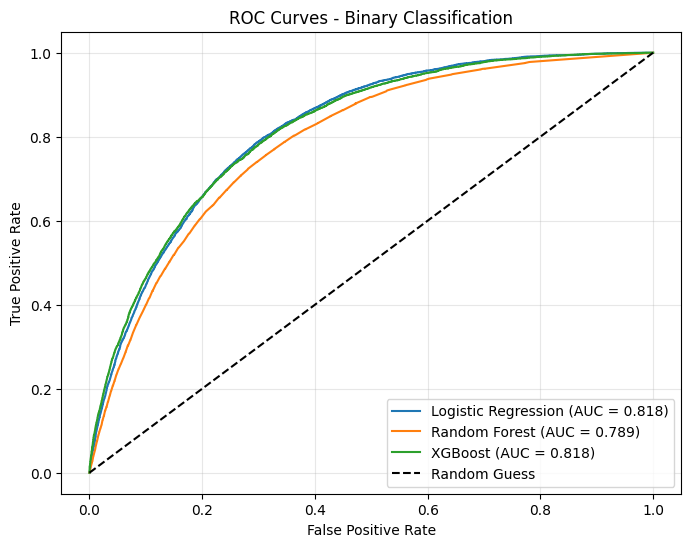

In [39]:
# Get prediction probabilities for ROC curves
log_probs = log_binary.predict_proba(X_test_b_scaled)[:, 1]
rf_probs = rf_binary.predict_proba(X_test_b)[:, 1]
xgb_probs = xgb_binary.predict_proba(X_test_b)[:, 1]

# Calculate ROC curves
log_fpr, log_tpr, _ = roc_curve(y_test_b, log_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_b, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_b, xgb_probs)

# Calculate AUC scores
log_auc = auc(log_fpr, log_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.3f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Binary Classification')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Model Comparison Summary

| Model | Accuracy | At Risk Recall | AUC | False Negatives |
|-------|----------|----------------|-----|-----------------|
| Logistic Regression | 73% | 76% | 0.818 | 1,914 |
| XGBoost | 72% | 76% | 0.818 | 1,889 |
| Random Forest | 84% | 19% | 0.789 | 6,436 |

Random Forest achieves higher accuracy by predicting "No Diabetes" for most cases, but it misses the majority of at-risk individuals. For a healthcare screening application, this is unacceptable.

Logistic Regression and XGBoost perform similarly. Since Logistic Regression is simpler, more interpretable, and clinically more relevent, we select it as the final model.

## Feature Importance

Understanding which health indicators contribute most to diabetes risk is valuable for both clinical interpretation and public health messaging. We examine feature importance from Logistic Regression coefficients.

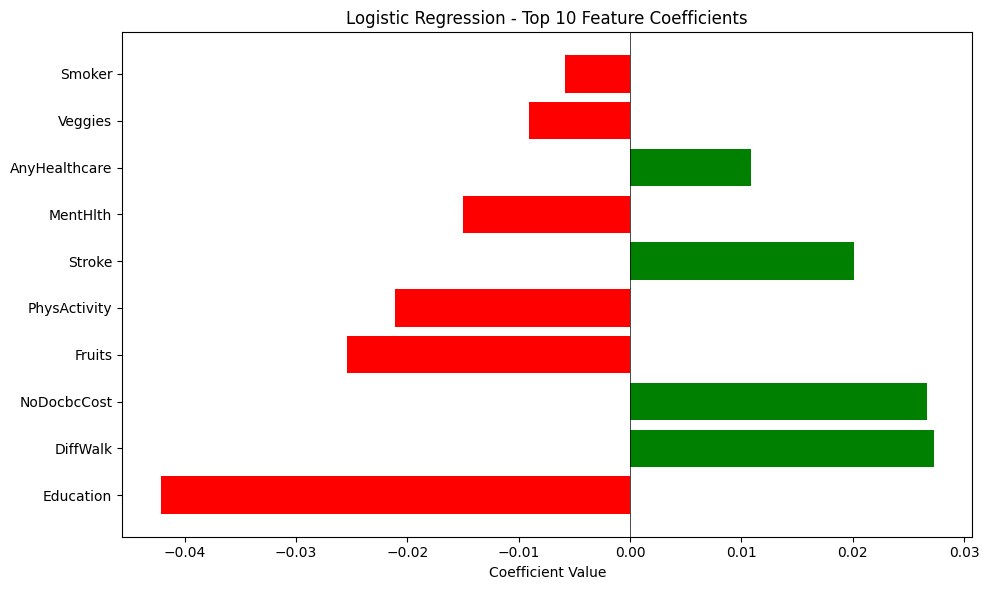

In [40]:
# Logistic Regression coefficients
feature_names = X.columns
# Creating a df with coefficients
log_coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_binary.coef_[0]
})

# We want to sort by importance regardless of positive/negative and therefore we take abs value
log_coeffs['Abs_Coefficient'] = abs(log_coeffs['Coefficient'])
log_coeffs = log_coeffs.sort_values('Abs_Coefficient')

# Plot
plt.figure(figsize=(10, 6))
top_10 = log_coeffs.head(10)  # Only top 10 features
colors = ['green' if c > 0 else 'red' for c in top_10['Coefficient']]  # Green = increases risk, Red = decreases risk
plt.barh(top_10['Feature'], top_10['Coefficient'], color=colors)  # Horizontal bar chart
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Top 10 Feature Coefficients')
plt.gca().invert_yaxis()  # Put most important at top
plt.axvline(x=0, color='black', linewidth=0.5)  # Line at zero
plt.tight_layout()
plt.savefig('feature_importance_lr.png', dpi=300, bbox_inches='tight')
plt.show()


### Interpretation of Top Features

The chart shows which health indicators most strongly influence diabetes risk prediction. Features are sorted by importance (absolute coefficient value). Green bars indicate factors that increase risk, while red bars indicate protective factors.

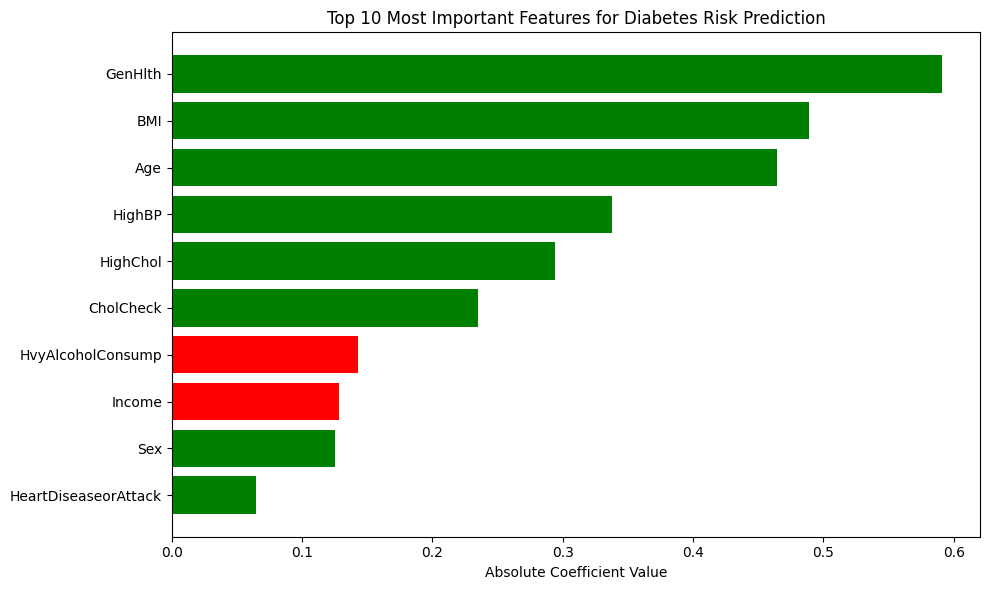

In [41]:
# Logistic Regression top 10 features by absolute importance
lr_coefs_sorted = log_coeffs.sort_values('Abs_Coefficient', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in lr_coefs_sorted['Coefficient']]
plt.barh(lr_coefs_sorted['Feature'], lr_coefs_sorted['Abs_Coefficient'], color=colors)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features for Diabetes Risk Prediction')
plt.tight_layout()
plt.savefig('feature_importance_top10.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insights from Feature Importance

**Risk Factors (green — increase diabetes risk):**
- **GenHlth:** Poor self-reported general health is the strongest predictor
- **BMI:** Higher body mass index significantly increases risk
- **Age:** Older individuals face higher risk
- **HighBP:** High blood pressure is strongly associated with diabetes
- **HighChol:** High cholesterol increases risk
- **CholCheck:** Having cholesterol checked (likely indicates existing health concerns)
- **Sex:** Being male slightly increases risk
- **HeartDiseaseorAttack:** History of heart disease increases risk

**Protective Factors (red — decrease diabetes risk):**
- **HvyAlcoholConsump:** Heavy alcohol consumption shows lower risk (this may reflect that diabetics are advised to reduce alcohol)
- **Income:** Higher income associated with lower risk

These findings align with established clinical knowledge. BMI, blood pressure, cholesterol, and age are well-documented diabetes risk factors. The socioeconomic link (income) highlights health disparities.

## Conclusions

### Research Question
Can we accurately predict an individual's diabetes risk with regards to health and lifestyle indicators using machine learning classfication?

### Answer
Yes, with reasonable effectiveness. Our final Logistic Regression model achieves:
- **76% recall** on at-risk individuals (catches 3 out of 4 people who need attention)
- **0.818 AUC** (strong discriminative ability)
- **73% overall accuracy**

### Key Findings

1. **Class imbalance matters:** Initial 3-class models failed to identify prediabetes due to extreme imbalance (2% of data). Switching to binary classification improved results significantly.

2. **Accuracy can be misleading:** Random Forest achieved 84% accuracy but only caught 19% of at-risk individuals. For healthcare screening, recall is more important than accuracy.

3. **Top risk factors identified:**
   - Poor general health
   - Higher BMI
   - Older individuals
   - High blood pressure
   - High Cholesterol levels

## Limitations

1. **Self-reported data:** All features come from survey responses, which may be subject to recall bias and inaccuracies.

2. **No lab values:** Clinical diabetes diagnosis relies on blood glucose levels, which are not included in this dataset. Our model predicts risk based on behavioral and demographic factors only.

3. **Prediabetes detection:** The model cannot reliably distinguish prediabetes from no diabetes. This limits early intervention opportunities.

4. **Cross-sectional data:** The dataset captures a single point in time. We cannot assess how risk changes over time or confirm actual diabetes development.

5. **Class imbalance:** Despite using class weights, the model still produces many false positives (11,766 healthy individuals flagged as at-risk).

## Recommendations

### For Public Health Organizations
1. Use the model as a preliminary screening tool to identify individuals who may benefit from further clinical testing
2. Focus outreach on modifiable risk factors: physical activity, diet, and access to healthcare

### For Healthcare Providers
1. Patients flagged as at-risk should receive blood glucose testing for confirmation
2. Consider the model as one input among many in clinical decision-making

### For Future Research
1. Incorporate lab values (blood glucose, A1C) if available to improve prediction accuracy
2. Explore time-series data to predict diabetes progression
3. Investigate why prediabetes is difficult to distinguish from no diabetes in survey data

In [42]:
# Save final model summary
print("=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"\nModel: Logistic Regression")
print(f"Features: {X.shape[1]}")
print(f"Training samples: {X_train_b.shape[0]}")
print(f"Test samples: {X_test_b.shape[0]}")
print(f"\nPerformance Metrics:")
print(f"  Accuracy: 73%")
print(f"  At-Risk Recall: 76%")
print(f"  At-Risk Precision: 34%")
print(f"  At-Risk F1-Score: 0.47")
print(f"  AUC: 0.818")
print(f"\nClass Weights Used: {class_weights_b}")

FINAL MODEL SUMMARY

Model: Logistic Regression
Features: 21
Training samples: 202944
Test samples: 50736

Performance Metrics:
  Accuracy: 73%
  At-Risk Recall: 76%
  At-Risk Precision: 34%
  At-Risk F1-Score: 0.47
  AUC: 0.818

Class Weights Used: {np.int64(0): np.float64(0.593535405528714), np.int64(1): np.float64(3.172784691388906)}
